In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import math
import os
import argparse
from functools import partial
from torch.nn import Sequential as Sq

In [2]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [3]:
def img_norm(img):
    return 2 * img - 1

def to_img(img):
    return 0.5 * (img + 1)


def update_ema(ema_model, model, ema_rate):
    for tar, src in zip(ema_model.parameters(), model.parameters()):
        tar.data.mul_(ema_rate).add_(src.data * (1 - ema_rate))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_positions=10000):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_positions = max_positions 
        self.half_dim = embed_dim // 2
        self.emb = math.log(max_positions) / (self.half_dim - 1)
        self.emb = torch.exp(torch.arange(self.half_dim).float() * -self.emb)
        self.register_buffer('proj', self.emb)
        self.pad = nn.Identity() if embed_dim % 2 == 0 else nn.ConstantPad1d((0, 1), value=0.)

    def forward(self, t):
        assert torch.max(t) <= 1.0 and torch.min(t) >= 0.0
        t = 0.1 * self.max_positions * t[:, None] * self.proj[None, :]
        return self.pad(torch.cat([torch.sin(t), torch.cos(t)], dim=-1))


class Base2FourierFeatures(nn.Module):
    def __init__(self, n_min=6, n_max=7):
        super().__init__()
        self.freq = torch.arange(n_min, n_max + 1)
        self.w = (2. ** self.freq) * 2 * torch.pi
        self.w = self.w.unflatten(0, (-1, 1, 1, 1))
        self.register_buffer('proj', self.w)

    def forward(self, x):
        x = (x.unsqueeze(1) * self.proj).flatten(1, 2)
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=1)
        return x


class Conv2d(nn.Conv2d):
    def __init__(self, cin, cout, kernel_size=3, stride=1, padding="same", dilation=1, groups=1, bias=True, init_scale=1.):
        super().__init__(cin, cout, kernel_size, stride, padding, dilation, groups, bias)
        self.init_scale = init_scale
        self.weight.data *= self.init_scale
        
    def reset_parameters(self):
        bound = 1./ np.sqrt(np.prod(self.weight.data.size()[1:]))
        nn.init.uniform_(self.weight.data, -bound, bound)
        if self.bias is not None:
            nn.init.zeros_(self.bias.data)


class Downsample(nn.Module):
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride

    def forward(self, x):
        x = F.interpolate(x, scale_factor=1./self.stride, mode='bilinear', align_corners=False)
        return x


class Upsample(nn.Module):
    def __init__(self, stride=2):
        super().__init__()
        self.stride = stride

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.stride, mode='bilinear', align_corners=False)
        return x


In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim=None, dor=0.05, bnr=1.0):
        super().__init__()
        mid_ch = int(bnr * in_ch)
        self.conv1 = Sq(nn.GroupNorm(32, in_ch),
                        nn.SiLU(inplace=True),
                        Conv2d(in_ch, mid_ch, 3))
        
        self.time = Conv2d(t_dim, mid_ch, 1, init_scale=0.) if t_dim is not None else None
        
        self.conv2 = Sq(nn.GroupNorm(32, mid_ch),
                        nn.SiLU(inplace=True),
                        nn.Dropout(p=dor),
                        Conv2d(mid_ch, out_ch, 3, init_scale=0.))
        
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, t=None):
        h = self.conv1(x)
        if t is not None:
            h = h + self.time(t)
        h = self.conv2(h)
        return h + self.skip(x)


class AttnBlock(nn.Module):
    def __init__(self, ch, num_heads=4, bnr=0.5):
        super().__init__()
        self.mid_ch = int(bnr * ch)
        self.ch, self.num_heads = ch, num_heads
        self.norm = nn.GroupNorm(32, self.ch)
        self.proj = Conv2d(ch, 3 * self.mid_ch, 1, bias=False)
        self.out = Conv2d(self.mid_ch, ch, 1, init_scale=0.)
        self.scale = (self.mid_ch // self.num_heads) ** -0.5

    def forward(self, x):
        h = self.norm(x)
        q, k, v = self.proj(h).flatten(-2, -1).unflatten(1, (self.num_heads * 3, -1)).chunk(3, dim=1)
        w = torch.matmul(q.transpose(-2, -1), k * self.scale)
        h = torch.matmul(v, w.softmax(dim=-2)).unflatten(-1, x.size()[2:]).flatten(1, 2)
        h = self.out(h)
        return x + h


In [19]:
class VPSDE(nn.Module):
    def __init__(self):
        super().__init__()
        base = torch.tensor([1e-4]).double()
        lsnr0 = base.expm1().log().neg().float()
        lsnr1 = base.add(10).exp().add(-1).log().neg().float()
        self.register_buffer('base', base)
        self.register_buffer('lsnr0', lsnr0)
        self.register_buffer('lsnr1', lsnr1)

    def sample_t(self, batch_size):
        return torch.rand(batch_size)

    def lsnr(self, t):
        return self.lsnr0 + (self.lsnr1 - self.lsnr0) * t
    
    def marg(self, t):
        lsnr = self.lsnr(t)
        alp = lsnr.sigmoid().sqrt()
        std = lsnr.neg().sigmoid().sqrt()
        return alp, std

    def f_and_g(self, t):
        alp, std = self.marg(t)
        v = std.square()
        dv_dt = (self.lsnr1 - self.lsnr0) * v * (v - 1)
        f = (- 0.5 * (1 - v).pow(-0.5) * dv_dt) / alp
        g = (dv_dt - 2 * f * v).sqrt()
        return f, g

    @torch.no_grad()
    def sample_euler(self, unet, num_samples, shape, num_steps=1000):
        device = self.lsnr0.device
        t = torch.ones(num_samples).to(device)
        x = torch.randn(num_samples, *shape).to(device)        
        t_vals = torch.linspace(1., 0., num_steps)
        dt = t_vals[0] - t_vals[1]
        for step, t_val in enumerate(t_vals):
            t.fill_(t_val)
            f, g = self.f_and_g(t_val)
            dw = dt.sqrt() * torch.randn_like(x)
            score = - unet(x, t) / self.marg(t_val)[1]
            dx = (f * x - (g**2) * score) * dt.neg() + g * dw
            x = x + dx
        
        return x


    @torch.no_grad()
    def reverse_process(self, z, model, num_steps):

        def forward_sn_coeff(alp_s, std_s, alp_t, std_t):
            falp_t = alp_t / alp_s
            fstd_t = (std_t.square() - std_s.square() * falp_t.square()).sqrt()
            return falp_t, fstd_t

        def reverse_sn_coeff(alp_s, std_s, alp_t, std_t):
            falp_t, fstd_t = forward_sn_coeff(alp_s, std_s, alp_t, std_t)
            rstd_s = std_s * fstd_t / std_t
            ralp_0 = rstd_s.square() * alp_s / std_s.square()
            ralp_t = rstd_s.square() * falp_t / fstd_t.square()
            return ralp_0, ralp_t, rstd_s


        time = torch.ones(z.size()[0]).to(z.device)
        reversed_time = torch.linspace(1., 0., num_steps + 1)
        dt = reversed_time[0] - reversed_time[1]
        for i in range(num_steps): # t -> s
            t = reversed_time[i]        
            s = reversed_time[i + 1]

            alp_s, std_s = self.marg(s)
            alp_t, std_t = self.marg(t)
            ralp_0, ralp_t, rstd_s = reverse_sn_coeff(alp_s, std_s, alp_t, std_t)
            time.fill_(t)
            eps_pred = model(z, time)
            z0_pred = (z - std_t * eps_pred) / alp_t
            rloc_s = ralp_0 * z0_pred + ralp_t * z
            z = rloc_s + torch.randn_like(z) * rstd_s
        return z0_pred

In [18]:
class UNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.img_ch  = args.img_ch
        self.main_ch = args.arch.main_ch
        self.n_layer = args.arch.n_layer 
        self.t_dim   = args.arch.t_dim
        self.ch_mult = args.arch.ch_mult
        self.use_attn = args.arch.use_attn

        self.chs = [self.main_ch * ch_mul for ch_mul in self.ch_mult]
        self.base_ch = self.chs[-1]
        
        self.use_pixel_fourier = args.arch.use_pixel_fourier

        self.stride = args.arch.stride
        self.num_levels = len(self.chs)

        if self.use_pixel_fourier:
            n_min, n_max = 6, 7
            self.pixel_fourier = Base2FourierFeatures(n_min=n_min, n_max=n_max)
            in_ch = (n_max + 1 - n_min) * self.img_ch * 2 + self.img_ch
        
        else:
            in_ch = self.img_ch

        self.from_rgb = Sq(Conv2d(in_ch, self.main_ch, 3),
                           nn.GroupNorm(32, self.main_ch), 
                           nn.SiLU(inplace=True),
                           Conv2d(self.main_ch, self.main_ch, 3))
        
        self.from_time = Sq(PositionalEmbedding(self.main_ch),
                            nn.Unflatten(-1, (-1, 1, 1)),
                            Conv2d(self.main_ch, self.t_dim, 1), 
                            nn.SiLU(inplace=True),
                            Conv2d(self.t_dim,   self.t_dim, 1), 
                            nn.SiLU())
        
        self.down     = []
        self.enc      = []
        self.enc_attn = []
        for l, n in enumerate(self.n_layer):
            in_ch = self.chs[l - 1] if l != 0 else self.main_ch
            out_ch = self.chs[l]
            stride = self.stride[l]
            use_attn = self.use_attn[l]
            down = nn.Identity() if stride == 1 else Downsample(stride)
            enc = [ResBlock(in_ch, out_ch, self.t_dim)]
            enc += [ResBlock(out_ch, out_ch, self.t_dim) for j in range(1, n)]
            enc = nn.ModuleList(enc)
            
            enc_attn = nn.ModuleList([AttnBlock(out_ch, num_heads=4) for j in range(n)]) if use_attn else None
            
            self.down += [down]
            self.enc  += [enc]
            self.enc_attn += [enc_attn]

        self.down     = nn.ModuleList(self.down)
        self.enc      = nn.ModuleList(self.enc)
        self.enc_attn = nn.ModuleList(self.enc_attn)

        self.mid_enc = ResBlock(self.base_ch, self.base_ch, t_dim=self.t_dim)
        self.mid_attn = AttnBlock(self.base_ch, num_heads=1, bnr=1.0)
        self.mid_dec = ResBlock(self.base_ch, self.base_ch, t_dim=self.t_dim)

        self.up       = []
        self.dec      = []
        self.dec_attn = []

        for l, n in enumerate(self.n_layer):
            in_ch = self.chs[l]
            out_ch = self.chs[l - 1] if l != 0 else self.main_ch
            stride = self.stride[l]
            use_attn = self.use_attn[l]

            dec_attn = nn.ModuleList([AttnBlock(in_ch, num_heads=4) for j in range(n)]) if use_attn else None
            dec = [ResBlock(2 * in_ch, in_ch, self.t_dim) for j in range(n - 1)]
            dec += [ResBlock(2 * in_ch, out_ch, self.t_dim)]
            dec = nn.ModuleList(dec)
            
            up = nn.Identity() if stride == 1 else Upsample(stride)
            self.dec_attn += [dec_attn]
            self.dec += [dec]
            self.up += [up]

        self.dec_attn = nn.ModuleList(self.dec_attn)
        self.dec      = nn.ModuleList(self.dec)
        self.up       = nn.ModuleList(self.up)

        self.to_rgb = Sq(nn.GroupNorm(32, self.main_ch), 
                         nn.SiLU(inplace=True),
                         Conv2d(self.main_ch, self.main_ch, 3),
                         nn.GroupNorm(32, self.main_ch), 
                         nn.SiLU(inplace=True),
                         Conv2d(self.main_ch, self.img_ch, 3, init_scale=0.))
        
    def forward(self, x, t):
        x_org = x
        if self.use_pixel_fourier:
            x = torch.cat([x, self.pixel_fourier(x)], 1)
        x, t = self.from_rgb(x), self.from_time(t)

        skip = []

        for i in range(self.num_levels):
            x = self.down[i](x)
            for j in range(self.n_layer[i]):
                x = self.enc[i][j](x, t)
                skip += [x]
                if self.enc_attn[i] is not None:
                    x = self.enc_attn[i][j](x)

        x = self.mid_enc(x, t)
        x = self.mid_attn(x)
        x = self.mid_dec(x, t)

        for i in range(self.num_levels)[::-1]:
            for j in range(self.n_layer[i]):
                if self.dec_attn[i] is not None:
                    x = self.dec_attn[i][j](x)
                x = self.dec[i][j](torch.cat([x, skip.pop()], 1), t)
            x = self.up[i](x)
        x = self.to_rgb(x)
        return x


In [22]:
args = argparse.Namespace()
args.arch = argparse.Namespace()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.batch_size = 32
args.learning_rate = 2e-4
args.num_epochs = 100
args.ema_rate = 0.9999
args.img_ch = 3
args.img_rsl = 32
args.arch.main_ch  = 128

assert args.arch.main_ch % 32 == 0, 'group norm'
args.arch.t_dim    = 4 * args.arch.main_ch
args.arch.ch_mult  = [    1,     2,     4,     4]
args.arch.n_layer  = [    5,     5,     5,     5]
args.arch.stride   = [    1,     2,     2,     2]
args.arch.use_attn = [False, False, False, False]
args.arch.use_pixel_fourier = True

model = UNet(args).to(args.device)
ema_model = copy.deepcopy(model)
ema_model.requires_grad_(False)
vpsde  = VPSDE().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
loss_meter = AverageMeter()

In [23]:
state_dict = torch.load("/content/drive/My Drive/" + "vdm2.pth")
model.load_state_dict(state_dict['model'])
ema_model.load_state_dict(state_dict['ema_model'])
optimizer.load_state_dict(state_dict['optimizer'])

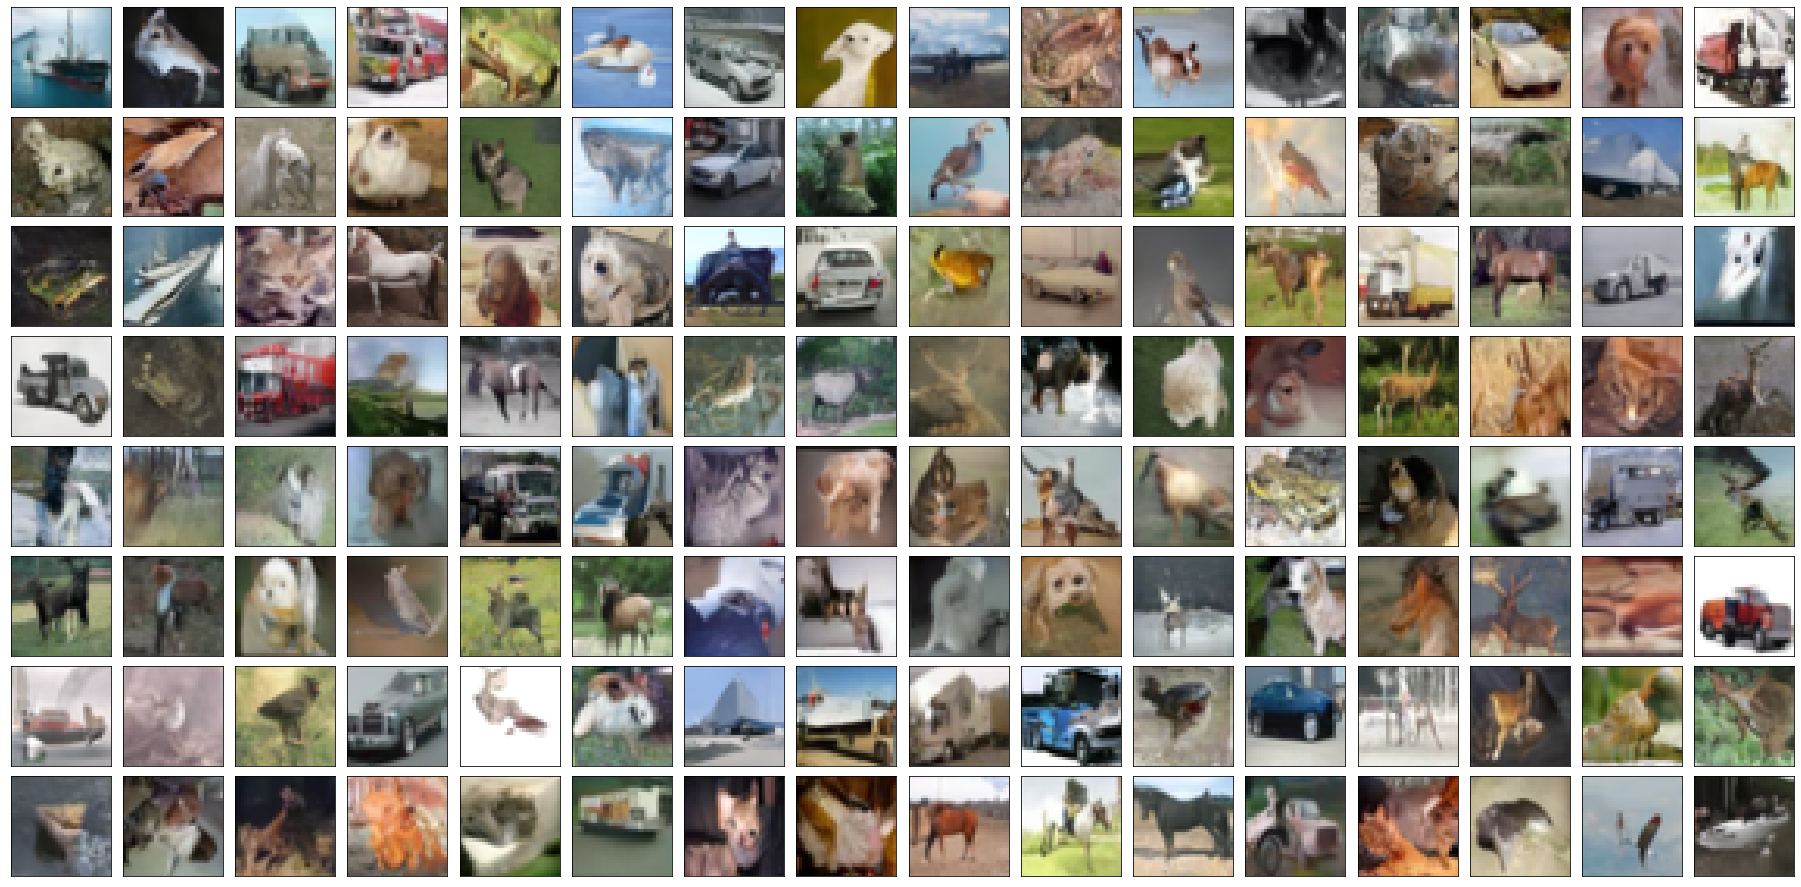

In [24]:
@torch.no_grad()
def generate(unet, vpsde, batch_size, num_steps):
    z = torch.randn(batch_size, 3, 32, 32).to(args.device)
    z = vpsde.reverse_process(z, unet, num_steps=num_steps)
    out = to_img(z).clamp(0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
    return out

@torch.no_grad()
def show():
    gen = generate(ema_model, vpsde, 128, 100)
    fig = plt.figure(figsize=(32, 16))

    for i in range(8 * 16):
        sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
        sub_fig.imshow(gen[i])

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

show()

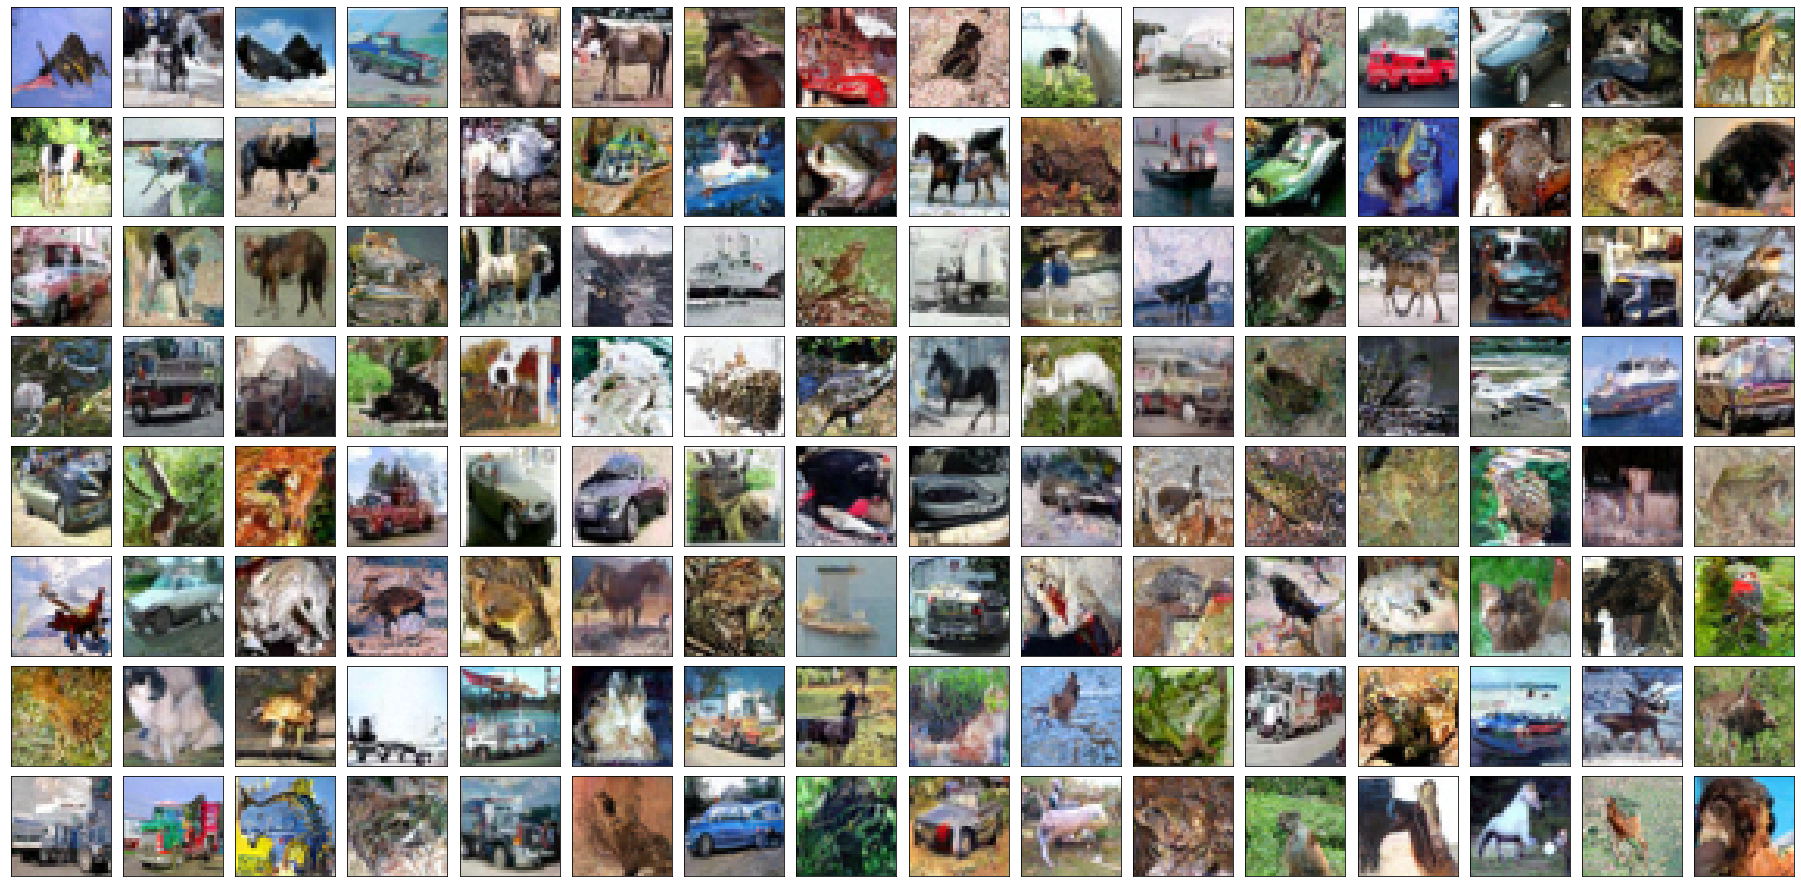

In [25]:

@torch.no_grad()
def generate(unet, vpsde, batch_size, num_steps):
    z = vpsde.sample_euler(unet, batch_size, (3, 32, 32), num_steps=num_steps)
    out = to_img(z).clamp(0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
    return out

@torch.no_grad()
def show():
    gen = generate(ema_model, vpsde, 128, 100)
    fig = plt.figure(figsize=(32, 16))

    for i in range(8 * 16):
        sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
        sub_fig.imshow(gen[i])

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

show()

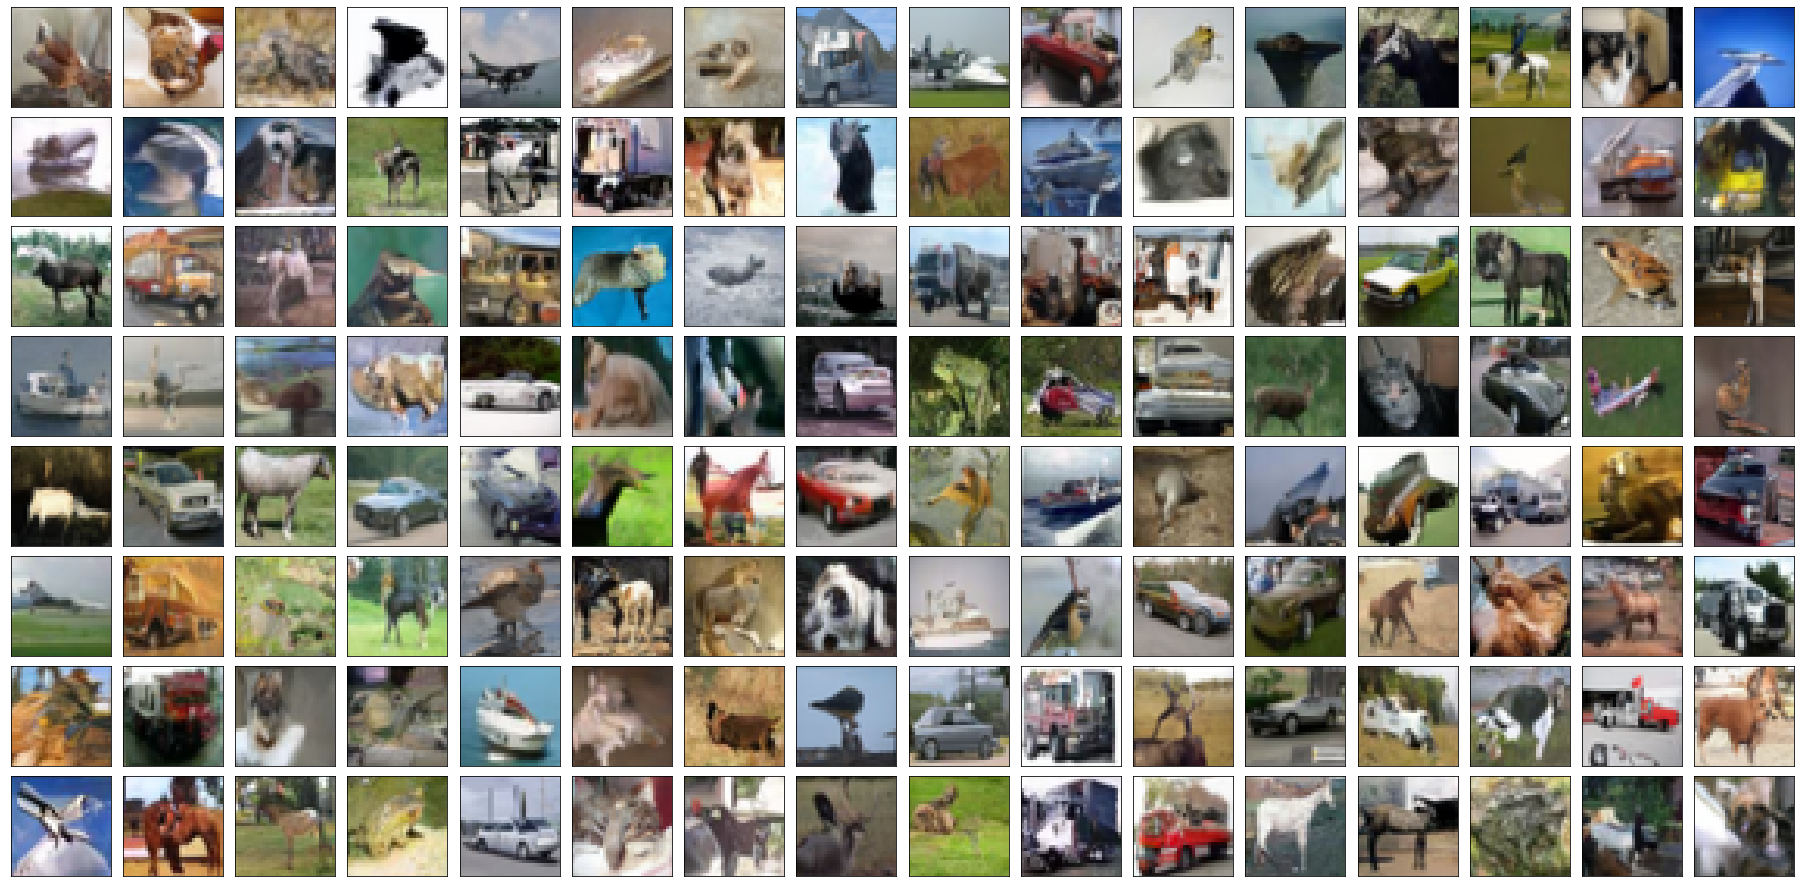

In [26]:
@torch.no_grad()
def generate(unet, vpsde, batch_size, num_steps):
    z = torch.randn(batch_size, 3, 32, 32).to(args.device)
    z = vpsde.reverse_process(z, unet, num_steps=num_steps)
    out = to_img(z).clamp(0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
    return out

@torch.no_grad()
def show():
    gen = generate(ema_model, vpsde, 128, 1000)
    fig = plt.figure(figsize=(32, 16))

    for i in range(8 * 16):
        sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
        sub_fig.imshow(gen[i])

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

show()

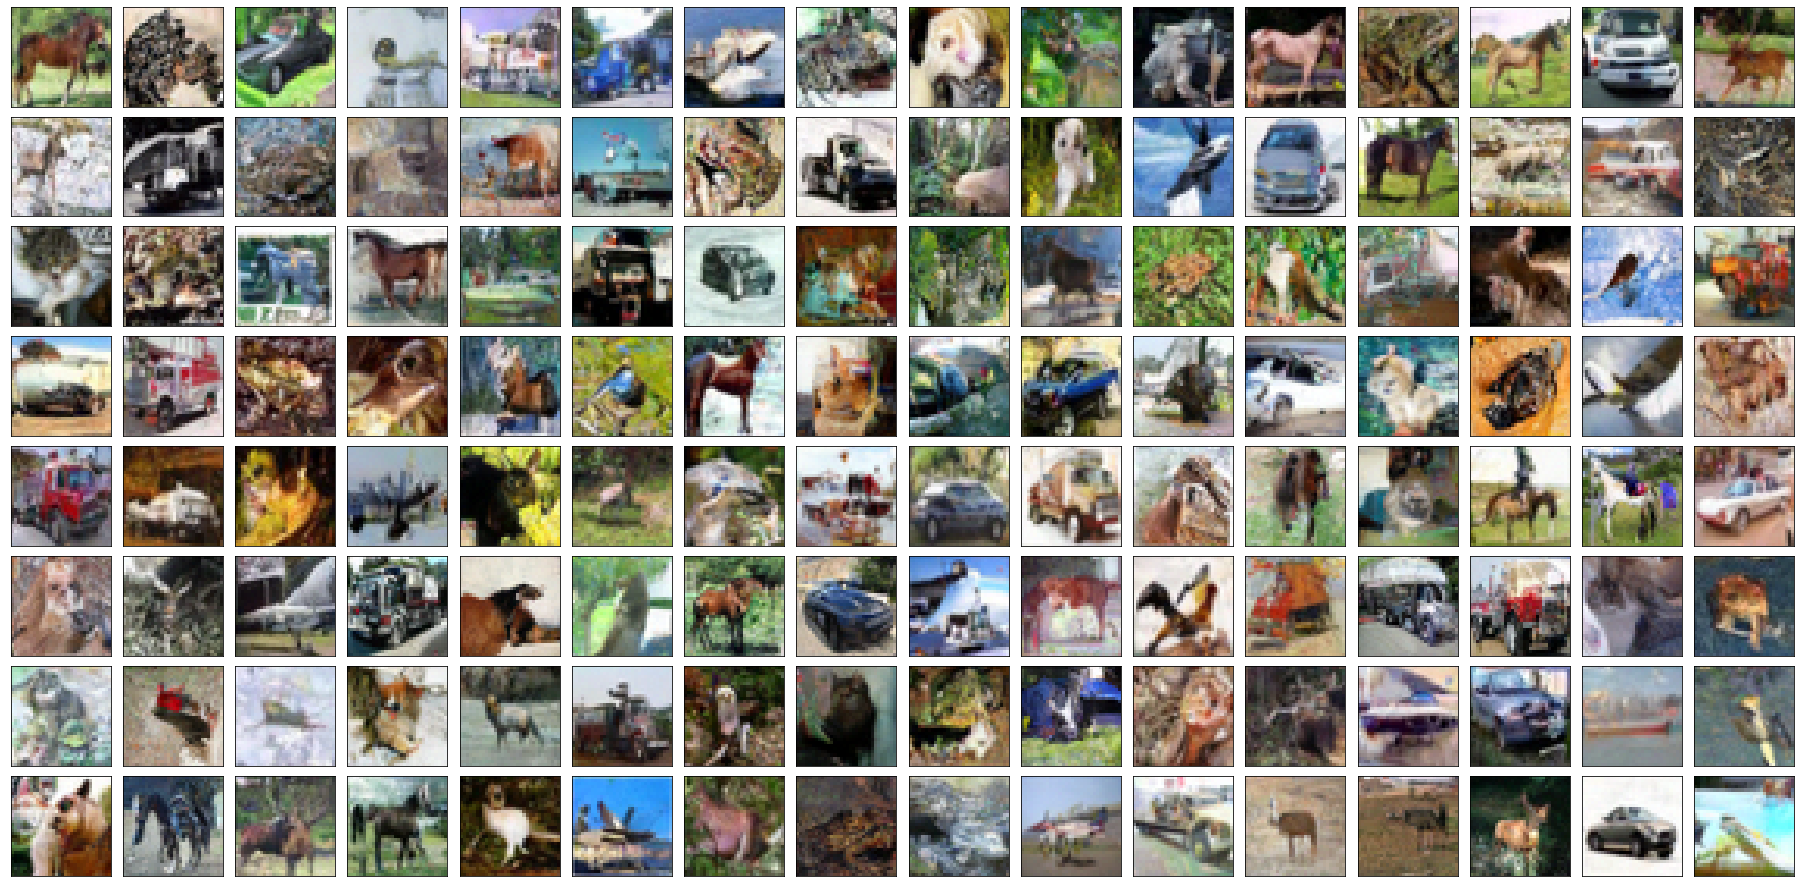

In [27]:

@torch.no_grad()
def generate(unet, vpsde, batch_size, num_steps):
    z = vpsde.sample_euler(unet, batch_size, (3, 32, 32), num_steps=num_steps)
    out = to_img(z).clamp(0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
    return out

@torch.no_grad()
def show():
    gen = generate(ema_model, vpsde, 128, 100)
    fig = plt.figure(figsize=(32, 16))

    for i in range(8 * 16):
        sub_fig = fig.add_subplot(8, 16, i + 1, xticks=[], yticks=[])
        sub_fig.imshow(gen[i])

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()

show()